# Lab 3: Residual layers and Squeezee and Excite

In this lab, we will write ResNet and SE Net.

The ResNet18 model has been shown in the figure.

<img src="img/ResNet18.JPG" title="ResNet18" style="width: 200px;" />

Same as lab 2, import all necessary library, and load image and transform images to 3x224x224

In [9]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

# setup device GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# make preprocess image function to resize images to 3x32x32
# Note: My GPU run 224x224 images of 4 batches - 700 seconds per epoch - is it killing me or killing my gpu... or both....
# That's why I use 32x32 of 128 batches for example...
preprocess = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])


# load CIFAR-10 and split into train, evaluation, and test set

# trainset: dataset, it contains images name from train dataset
# root = './data' : place images data into directory ./data
# download = True : If there is no data inside directory ./data, download it.
# transform = preprocess : convert all images with preprocess function
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)

# split trainset into train set and evaluation set as random index
# The trainset of CIFAR-10 has 50,000 data. Thus, we can separate data into 80%/20%
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

# testset: dataset, it contains images name from test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)

# when start, the images data has not been loaded. It will be loaded when call trainloader, valloader, and test loader
# batch_size: image data in each iteration
# shuffle: load images with random shuffle or not
# num_workers: number of thread used when load images set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                        shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

dataloaders = {'train': trainloader, 'val': valloader}

Files already downloaded and verified
Files already downloaded and verified


## Residual block

The Residual block is a common block which has combination of CNN and input data. In ResNet18, ResNet34, they use only basic concept of residual block, but the ResNet50, ResNet101, and ResNet152 use a little bit advance residual block called bottleneck. Why? I think it because the parameters are too much.

The residual block can show in figure:

<img src="img/residualblock.png" title="Residual block" style="width: 640px;" />

As you see, the residual block has 2 styles: with and without 1x1CNN at the shortcut line. It is up to the input and output kernel size. 1x1 convolution has responsibility on re-kernel size.

The code is modified from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [11]:
class BasicBlock(nn.Module):
    '''
    Basic block = Normal Residual block

    1 Residual block has 2 CNN: 2 layers/block
    '''
    expansion = 1

    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        # if the kernel size of output is not equal with input, reshape it with 1x1 CNN
        if stride != 1 or in_planes != self.expansion*out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out

In [12]:
class Bottleneck(nn.Module):
    '''
    Bottleneck block = advance Residual block, use for Resnet50 to upper

    1 Residual block has 3 CNN: 3 layers/block
    '''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        # if the kernel size of output is not equal with input, reshape it with 1x1 CNN
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## Create full stack of Resnet

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        #Start blocks: 1 layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
def ResNet18(num_classes = 10):
    '''
    Start layer: 1
    4 sets of residual layer, [2, 2, 2, 2] each set: 2*2 + 2*2 + 2*2 + 2*2 = 16
    last FC layer: 1

    Total layers: 1+16+1= 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    '''
    Start layer: 1
    4 sets of residual layer, [3, 4, 6, 3] each set: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1

    Total layers: 1+32+1= 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    Start layer: 1
    4 sets of residual layer, [3, 4, 6, 3] each set: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1

    Total layers: 1+48+1= 50
    '''
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    Start layer: 1
    4 sets of residual layer, [3, 4, 23, 3] each set: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1

    Total layers: 1+99+1= 101
    '''
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    Start layer: 1
    4 sets of residual layer, [3, 8, 36, 3] each set: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1

    Total layers: 1+150+1= 152
    '''
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

OK test it

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    This comment is an example for create documents like help file format.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # print('outputs', outputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [19]:
resnet = ResNet18().to(device)
# Make optimizer and Loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
# this time, use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)

best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 25, 'resnet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.7812 Acc: 0.3448
Epoch time taken:  21.92812180519104
val Loss: 1.4615 Acc: 0.4551
Epoch time taken:  23.11958408355713

Epoch 1/24
----------
train Loss: 1.3146 Acc: 0.5226
Epoch time taken:  21.950345277786255
val Loss: 1.1715 Acc: 0.5847
Epoch time taken:  23.13689422607422

Epoch 2/24
----------
train Loss: 1.0078 Acc: 0.6437
Epoch time taken:  21.92682456970215
val Loss: 1.0183 Acc: 0.6528
Epoch time taken:  23.112229108810425

Epoch 3/24
----------
train Loss: 0.8034 Acc: 0.7163
Epoch time taken:  21.948993921279907
val Loss: 0.8569 Acc: 0.7023
Epoch time taken:  23.143240213394165

Epoch 4/24
----------
train Loss: 0.6402 Acc: 0.7742
Epoch time taken:  21.940918684005737
val Loss: 0.7862 Acc: 0.7309
Epoch time taken:  23.132933616638184

Epoch 5/24
----------
train Loss: 0.4916 Acc: 0.8273
Epoch time taken:  21.92019033432007
val Loss: 0.7073 Acc: 0.7590
Epoch time taken:  23.106813192367554

Epoch 6/24
----------
train Loss: 0.3656 Acc: 0.873

# Squeeze and Excite Net

Squeeze and Excite (SENet) has shown in figure:

<img src="img/SENET.png" title="se block" style="width: 640px;" />

The SENet model came from: https://github.com/moskomule/senet.pytorch/blob/23839e07525f9f5d39982140fccc8b925fe4dee9/senet/se_module.py#L4

In [20]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

SE Net can be added in any position as you like:

<img src="img/SENETAdd.png" title="se add" style="width: 640px;" />

In our example, use 'b' concept.

In [21]:
class ResidualSEBasicBlock(nn.Module):
    '''
    Basic block = Normal Residual block

    1 Residual block has 2 CNN: 2 layers/block
    '''
    expansion = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super(ResidualSEBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.se = SELayer(out_planes, reduction)            # <<< SENet

        self.shortcut = nn.Sequential()
        # if the kernel size of output is not equal with input, reshape it with 1x1 CNN
        if stride != 1 or in_planes != self.expansion*out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out

In [22]:
def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

#### Train it and compare
- Time spending when training
- Accuracy

In [26]:
ressenet = ResSENet18().to(device)
# Make optimizer and Loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
# this time, use Adam optimization
optimizer2 = optim.Adam(params_to_update2, lr=0.01)

best_model2, val_acc_history2, loss_acc_history2 = train_model(ressenet, dataloaders, criterion2, optimizer2, 25, 'ressenet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.6738 Acc: 0.3813
Epoch time taken:  23.310951232910156
val Loss: 1.4468 Acc: 0.4674
Epoch time taken:  24.592353582382202

Epoch 1/24
----------
train Loss: 1.2096 Acc: 0.5621
Epoch time taken:  23.3079195022583
val Loss: 1.0929 Acc: 0.6111
Epoch time taken:  24.585301876068115

Epoch 2/24
----------
train Loss: 0.9372 Acc: 0.6667
Epoch time taken:  23.300679445266724
val Loss: 1.0596 Acc: 0.6356
Epoch time taken:  24.57485580444336

Epoch 3/24
----------
train Loss: 0.7527 Acc: 0.7338
Epoch time taken:  23.305675745010376
val Loss: 0.7976 Acc: 0.7176
Epoch time taken:  24.589216470718384

Epoch 4/24
----------
train Loss: 0.5963 Acc: 0.7899
Epoch time taken:  23.41267156600952
val Loss: 0.7086 Acc: 0.7598
Epoch time taken:  24.697813987731934

Epoch 5/24
----------
train Loss: 0.4578 Acc: 0.8405
Epoch time taken:  23.34851837158203
val Loss: 0.6542 Acc: 0.7827
Epoch time taken:  24.632187366485596

Epoch 6/24
----------
train Loss: 0.3458 Acc: 0.877

In [24]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'loss of normal')
    plt.plot(loss_acc_history2, label = 'loss of adding SENet')
    plt.title('Accuracy in each epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'acc of normal')
    plt.plot(val_acc_history2, label = 'acc of adding SENet')
    plt.title('Loss value in each epoch')
    plt.legend()
    plt.show()

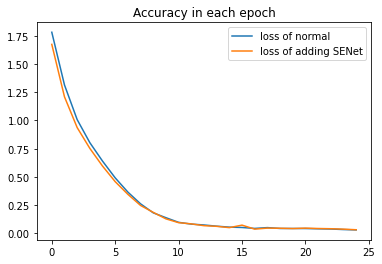

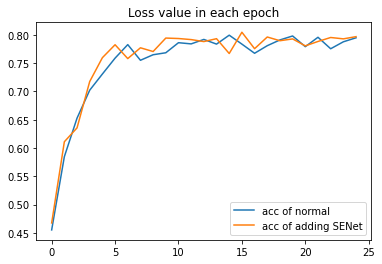

In [27]:
plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2)

# Dear dr. Matt

What we can do for this lab? (Please select 2-4 topics, unless we will hear the students' scream.)
- Add SENet in any position
- Make InceptionSeNet
- Compare Resnet and ResSENet untill the Resnet is collapsed (If you want to destroy your GPU)
- Adapt ResNet to ResNext or InceptionResNet or InceptionResSENet (Or... Do you want to try DenseNet? :) )
- Try to train the experiment in CIFAR or ImageNet and test it to outside test dataset.

### DenseNet

<img src="img/densenet.png" title="densenet" style="width: 640px;" />



Ok, I would like to use this lab in some contest such as Chihuahua-muffin, cake-muffin, or dog-bagel ^_^ . I think it is funny!

There are many cite to search about it.

https://www.topbots.com/chihuahua-muffin-searching-best-computer-vision-api/?amp

https://medium.com/@cristianduguet/chihuahua-or-muffin-51bca039e175

https://arxiv.org/ftp/arxiv/papers/1801/1801.09573.pdf


Download test dataset in 

https://github.com/ieee8023/deep-learning-datasets/tree/master/chihuahua-muffin

but we will not let them use the testset in trainset :D

I tried to find ImageNet dataset and separate only dogs and muffin, but I don't know how.